In [575]:
import astropy.io.fits as fits
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from astropy.visualization import simple_norm
import ccdproc as ccd
from astropy import visualization as viz
from astropy.visualization import (imshow_norm, MinMaxInterval, SqrtStretch, ZScaleInterval)
from astropy.coordinates import SkyCoord
from photutils.aperture import ApertureStats
from astropy.stats import SigmaClip
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from astropy.wcs import WCS
from astropy.table import Table
from astropy.io import ascii
from astropy import units as u
from datetime import datetime
from astropy.time import Time
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit
from astropy.visualization import ImageNormalize
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon

# Data Reduction

### Files

In [2]:
directory = '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/*'
glob(directory)

['/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/alberio',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/bias',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/calibration',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/dark',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/deneb',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/epsPeg',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/europa',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/flat',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/jupiter',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/sun',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/vega']

In [3]:
directory2 = '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/mygroup/*'
glob(directory2)

['/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/mygroup/bias',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/mygroup/calibration',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/mygroup/dark',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/mygroup/flat',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/mygroup/sky',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/mygroup/vega']

In [4]:
files_bias = glob(glob(directory)[1]+'/*')
files_dark = glob(glob(directory)[3]+'/*')
files_flat = glob(glob(directory)[7]+'/*')
files_cali = glob(glob(directory)[2]+'/*')
files_albr = glob(glob(directory)[0]+'/*')
files_denb = glob(glob(directory)[4]+'/*')
files_epsP = glob(glob(directory)[5]+'/*')
files_euro = glob(glob(directory)[6]+'/*')
files_jupi = glob(glob(directory)[8]+'/*')
files_sunn = glob(glob(directory)[9]+'/*')
files_vega = glob(glob(directory)[10]+'/*')

In [5]:
files_bias2 = glob(glob(directory2)[0]+'/*')
files_dark2 = glob(glob(directory2)[2]+'/*')
files_flat2 = glob(glob(directory2)[3]+'/*')
files_cali2 = glob(glob(directory2)[1]+'/*')

In [6]:
ccd_shape = fits.getdata(files_bias[0]).shape

In [568]:
files = [files_bias[0],
            files_dark_07[0],
            files_dark_15[0],
            files_dark_30[0],
            files_dark_40[0],
            files_flat[0],
            files_cali[0],
            files_cali[1],
            files_albr[0],
            files_denb[0],
            files_epsP[0],
            files_euro[0],
            files_jupi[0],
            files_sunn[0],
            files_vega[0],
            files_bias2[0],
            files_dark2_10[0],
            files_dark2_20[0],
            files_dark2_40[0],
            files_dark2_50[0],
            files_dark2_60[0],   
            files_flat2[0],
            files_cali2[0],
            files_cali2[1],
            files_cali2[2],
        ]
target = ['Bias', 'Dark', 'Dark', 'Dark', 'Dark', 'Flat', 'Hg', 'Ne', 'Albireo', 'Deneb', 'Epsilon Peg', 
          'Europa', 'Jupiter', 'Moon/Sun', 'Vega', 'Bias', 'Dark', 'Dark', 'Dark', 'Dark', 'Dark', 'Flat', 'H', 'Hg', 'Ne']
exp_time = []
time_obs = []
num_expo = [len(files_bias),
            len(files_dark_07),
            len(files_dark_15),
            len(files_dark_30),
            len(files_dark_40),
            len(files_flat),
            1,#files_cali[0],
            1,#files_cali[1],
            len(files_albr),
            len(files_denb),
            len(files_epsP),
            len(files_euro),
            len(files_jupi),
            len(files_sunn),
            len(files_vega),
            len(files_bias2),
            len(files_dark2_10),
            len(files_dark2_20),
            len(files_dark2_40),
            len(files_dark2_50),
            len(files_dark2_60),  
            len(files_flat2),
            1,#files_cali2[0],
            1,#files_cali2[1],
            1#files_cali2[2],
           ]
ra =  ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-','-','-']
dec = ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-','-','-']
names = ['Target', 'Exposure Time', 'Obs. Time', 'Number of Exposures', 'Right Ascension', 'Declination']

for file in files:
    head = fits.getheader(file)
    exp_time.append(head['EXPTIME'])
    time_obs.append(head['DATE-OBS'])
    #num_expo.append(len(file))
    
dark_files = [  files_dark_07,
                files_dark_15,
                files_dark_30,
                files_dark_40,
                files_dark2_10,
                files_dark2_20,
                files_dark2_40,
                files_dark2_50,
                files_dark2_60]

#tblr_obs = Table()

In [571]:
# Albireo
ra[8]  = '19h 30m 43.286s'
dec[8] = '+27$^{\circ}$ 57\' 34.84\"'

# Deneb
ra[9]  = '20h 41m 25.9s'
dec[9] = '+45$^{\circ}$ 16\' 49\"'

# Eps Peg
ra[10]  = '21h 44m 11.15614s'
dec[10] = '+09$^{\circ}$ 52\' 30.0311\"'

# Vega
ra[14]  = '18h 36m 56.33635s'
dec[14] = '+38$^{\circ}$ 47\' 01.2802\"'

In [581]:
jupi_timeobs = Time(fits.getheader(files_jupi[0])['DATE-OBS'])
moon_timeobs = Time(fits.getheader(files_sunn[0])['DATE-OBS'])
lat = 29.651634*u.deg
lon = -82.324829*u.deg
loc = EarthLocation(lat=lat, lon=lon, height=117*u.m)

In [579]:
jupi_body = get_body('jupiter', jupi_timeobs, loc)

In [584]:
jupi_body.ra

<Longitude 359.22368452 deg>

In [585]:
jupi_body.dec

<Latitude -1.90009307 deg>

In [ ]:
#ra[12] 
  =#dec[12] = 

In [582]:
moon_body = get_body('moon', moon_timeobs, loc)

In [572]:
tblr_obs = Table([target, exp_time, time_obs, num_expo, ra, dec], names=names)

### Bias

In [7]:
bias = np.zeros((len(files_bias), ccd_shape[0], ccd_shape[1]))
for file in range(len(files_bias)):
    bias[file] = fits.getdata(files_bias[file])

(<matplotlib.image.AxesImage at 0x7f5042d0f8e0>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f504b157dc0>)

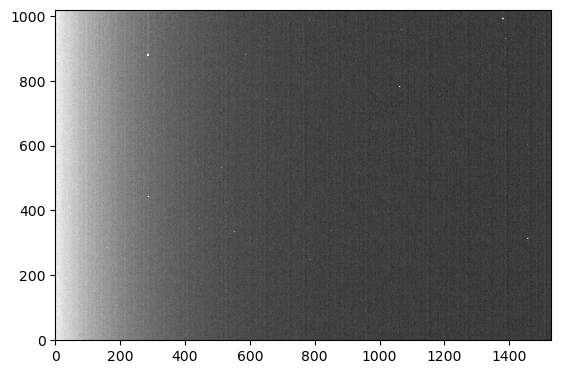

In [8]:
master_bias = np.median(bias, axis=0)
imshow_norm(master_bias, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [9]:
bias2 = np.zeros((len(files_bias2), ccd_shape[0], ccd_shape[1]))
for file in range(len(files_bias2)):
    bias2[file] = fits.getdata(files_bias2[file])

(<matplotlib.image.AxesImage at 0x7f5041412a60>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f5042ccda00>)

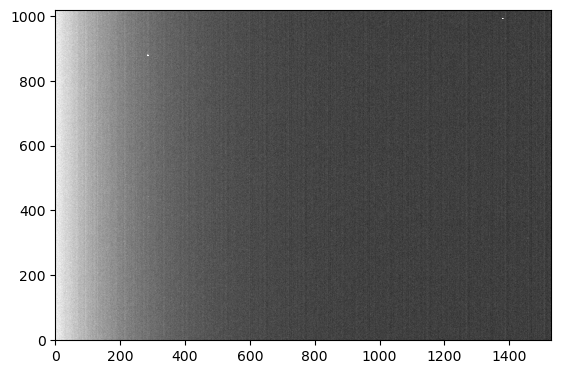

In [10]:
master_bias2 = np.median(bias2, axis=0)
imshow_norm(master_bias2, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

### Dark

#### Other Group

In [11]:
files_dark_07 = glob(files_dark[2]+'/*')
files_dark_15 = glob(files_dark[0]+'/*')
files_dark_30 = glob(files_dark[3]+'/*')
files_dark_40 = glob(files_dark[1]+'/*')

In [12]:
dark_07 = np.zeros((len(files_dark_07), ccd_shape[0], ccd_shape[1]))
exptime_dark_07 = fits.getheader(files_dark_07[0])['EXPTIME']
for file in range(len(files_dark_07)):
    dark_07[file] = fits.getdata(files_dark_07[file])

(<matplotlib.image.AxesImage at 0x7f5041392580>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f5042c7ab80>)

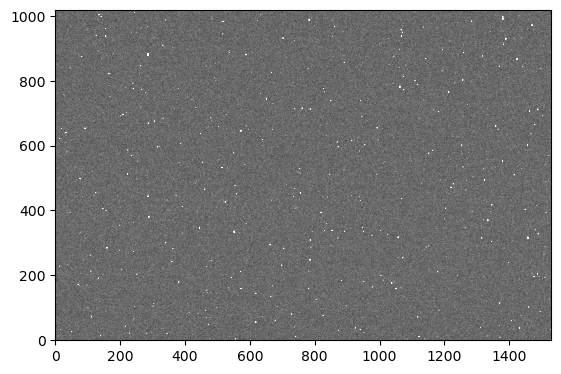

In [13]:
master_dark_07 = np.median(dark_07-master_bias, axis=0)
imshow_norm(master_dark_07, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [14]:
dark_15 = np.zeros((len(files_dark_15), ccd_shape[0], ccd_shape[1]))
exptime_dark_15 = fits.getheader(files_dark_15[0])['EXPTIME']
for file in range(len(files_dark_15)):
    dark_15[file] = fits.getdata(files_dark_15[file])

(<matplotlib.image.AxesImage at 0x7f504137d670>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f504135aa60>)

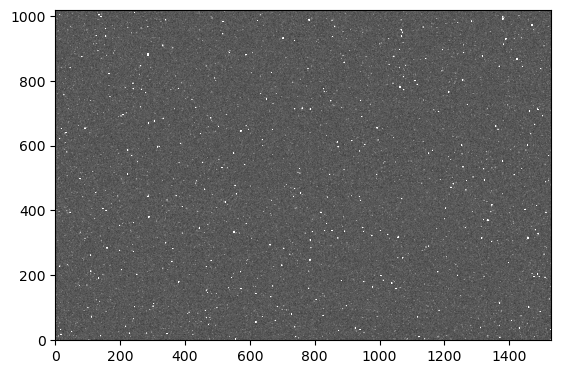

In [15]:
master_dark_15 = np.median(dark_15-master_bias, axis=0)
imshow_norm(master_dark_15, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [16]:
dark_30 = np.zeros((len(files_dark_30), ccd_shape[0], ccd_shape[1]))
exptime_dark_30 = fits.getheader(files_dark_30[0])['EXPTIME']
for file in range(len(files_dark_30)):
    dark_30[file] = fits.getdata(files_dark_30[file])

(<matplotlib.image.AxesImage at 0x7f50412e4850>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f50414344c0>)

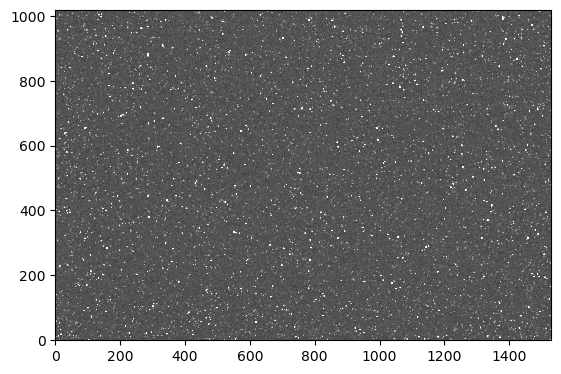

In [17]:
master_dark_30 = np.median(dark_30-master_bias, axis=0)
imshow_norm(master_dark_30, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [18]:
dark_40 = np.zeros((len(files_dark_40), ccd_shape[0], ccd_shape[1]))
exptime_dark_40 = fits.getheader(files_dark_40[0])['EXPTIME']
for file in range(len(files_dark_40)):
    dark_40[file] = fits.getdata(files_dark_40[file])

(<matplotlib.image.AxesImage at 0x7f5041250a30>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f50413c0280>)

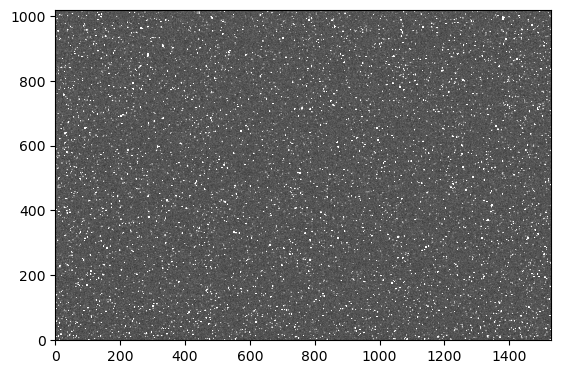

In [19]:
master_dark_40 = np.median(dark_40-master_bias, axis=0)
imshow_norm(master_dark_40, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

#### My Group

In [20]:
files_dark2_10 = glob(files_dark2[3]+'/*')
files_dark2_20 = glob(files_dark2[4]+'/*')
files_dark2_40 = glob(files_dark2[1]+'/*')
files_dark2_50 = glob(files_dark2[0]+'/*')
files_dark2_60 = glob(files_dark2[2]+'/*')

In [21]:
dark2_10 = np.zeros((len(files_dark2_10), ccd_shape[0], ccd_shape[1]))
exptime_dark2_10 = fits.getheader(files_dark2_10[0])['EXPTIME']
for file in range(len(files_dark2_10)):
    dark2_10[file] = fits.getdata(files_dark2_10[file])

(<matplotlib.image.AxesImage at 0x7f50412408b0>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f5041282790>)

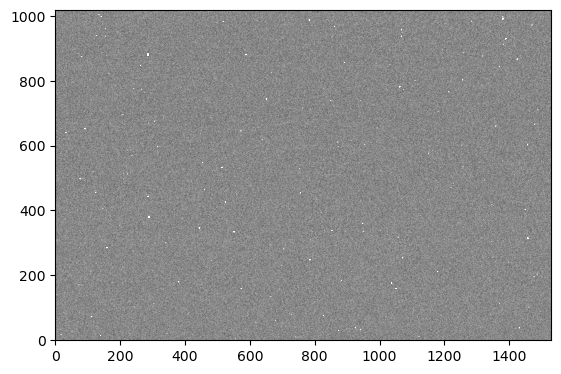

In [22]:
master_dark2_10 = np.median(dark2_10-master_bias2, axis=0)
imshow_norm(master_dark2_10, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [23]:
dark2_20 = np.zeros((len(files_dark2_20), ccd_shape[0], ccd_shape[1]))
exptime_dark2_20 = fits.getheader(files_dark2_20[0])['EXPTIME']
for file in range(len(files_dark2_20)):
    dark2_20[file] = fits.getdata(files_dark2_20[file])

(<matplotlib.image.AxesImage at 0x7f503e211ac0>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f503e251e20>)

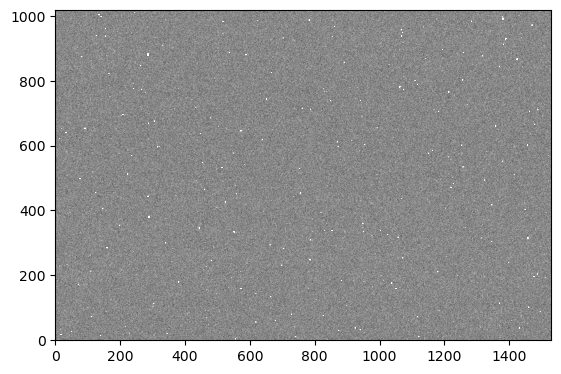

In [24]:
master_dark2_20 = np.median(dark2_20-master_bias2, axis=0)
imshow_norm(master_dark2_20, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [25]:
dark2_40 = np.zeros((len(files_dark2_40), ccd_shape[0], ccd_shape[1]))
exptime_dark2_40 = fits.getheader(files_dark2_40[0])['EXPTIME']
for file in range(len(files_dark2_40)):
    dark2_40[file] = fits.getdata(files_dark2_40[file])

(<matplotlib.image.AxesImage at 0x7f503e175ac0>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f503e1c23a0>)

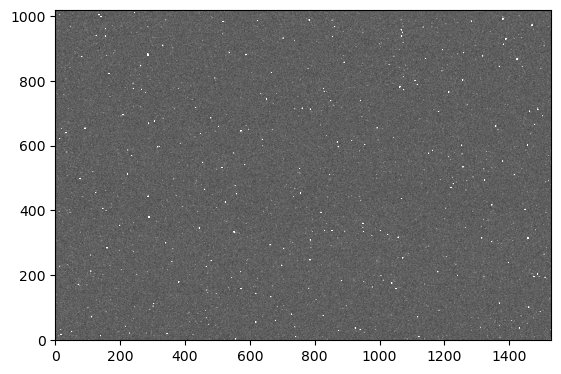

In [26]:
master_dark2_40 = np.median(dark2_40-master_bias2, axis=0)
imshow_norm(master_dark2_40, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [27]:
dark2_50 = np.zeros((len(files_dark2_50), ccd_shape[0], ccd_shape[1]))
exptime_dark2_50 = fits.getheader(files_dark2_50[0])['EXPTIME']
for file in range(len(files_dark2_50)):
    dark2_50[file] = fits.getdata(files_dark2_50[file])

(<matplotlib.image.AxesImage at 0x7f503e15ec70>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f503e128220>)

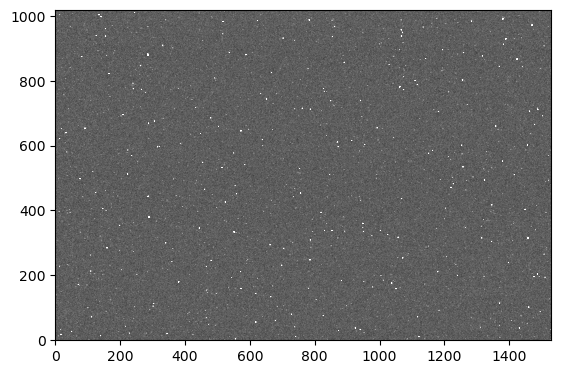

In [28]:
master_dark2_50 = np.median(dark2_50-master_bias2, axis=0)
imshow_norm(master_dark2_50, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [29]:
dark2_60 = np.zeros((len(files_dark2_60), ccd_shape[0], ccd_shape[1]))
exptime_dark2_60 = fits.getheader(files_dark2_60[0])['EXPTIME']
for file in range(len(files_dark2_60)):
    dark2_60[file] = fits.getdata(files_dark2_60[file])

(<matplotlib.image.AxesImage at 0x7f503e0c8e20>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f503e2213d0>)

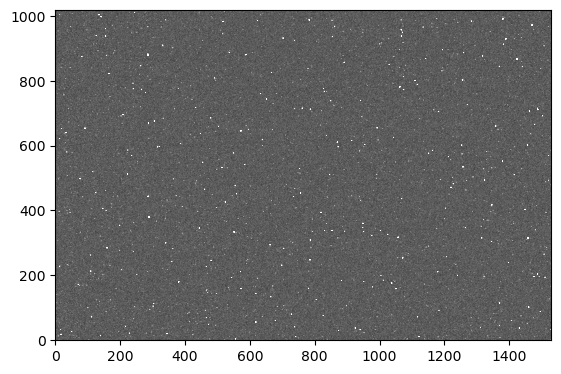

In [30]:
master_dark2_60 = np.median(dark2_60-master_bias2, axis=0)
imshow_norm(master_dark2_60, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

### Flat

#### Other Group

In [31]:
flat = np.zeros((len(files_flat), ccd_shape[0], ccd_shape[1]))
exptime_flat = fits.getheader(files_flat[0])['EXPTIME']
for file in range(len(files_flat)):
    flat[file] = fits.getdata(files_flat[file])

(<matplotlib.image.AxesImage at 0x7f503e043160>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f503e1cb1f0>)

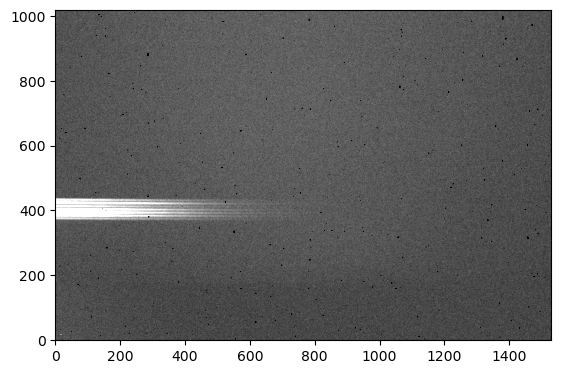

In [32]:
master_flat = np.median(flat-master_bias-(exptime_flat/exptime_dark_07)*master_dark_07, axis=0)
imshow_norm(master_flat, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [33]:
np.mean(master_flat)

22.085019131835743

In [34]:
master_norm_flat = master_flat / np.mean(master_flat)
np.mean(master_norm_flat)

0.9999999999999992

#### My Group

In [35]:
flat2 = np.zeros((len(files_flat2), ccd_shape[0], ccd_shape[1]))
exptime_flat2 = fits.getheader(files_flat2[0])['EXPTIME']
for file in range(len(files_flat2)):
    flat2[file] = fits.getdata(files_flat2[file])

(<matplotlib.image.AxesImage at 0x7f503dfa8850>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f503dfeef10>)

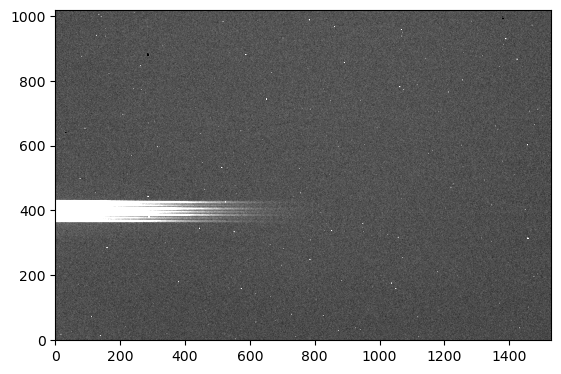

In [36]:
master_flat2 = np.median(flat2-master_bias2-(exptime_flat2/exptime_dark2_10)*master_dark2_10, axis=0)
imshow_norm(master_flat2, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [37]:
master_norm_flat2 = master_flat2 / np.mean(master_flat2)
np.mean(master_norm_flat2)

1.0000000000000004

### Wavelength Calibration

$[master\_flat-\frac{exptime\_flat}{exptime\_dark}(master\_dark)]_{ave}[\frac{(object-master\_bias)
-\frac{exptime\_obj}{exptime\_dark}(master\_dark)}{(master\_flat)-\frac{exptime\_flat}{exptime\_dark}(master\_dark)}]_{pix}$

$[(flat-bias)-\frac{t_f}{t_d}(dark-bias)]_{ave}[\frac{(object-bias)-\frac{t_o}{t_d}(dark-bias)}{(flat-bias)-\frac{t_f}{t_d}(dark-bias)}]_{pix}$

In [38]:
def lin_fit(x, m, b):
    return m*x+b
def quad_fit(x, a, b, c):
    return a*x**2 + b*x + c
def gauss_fit(x, a, x0, sigma):
    return a*np.exp(-1*(x-x0)**2/(2*sigma**2))

#### Other Group

In [39]:
files_cali

['/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/calibration/cal_Hg_7s.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/calibration/cal_neon_10s.FIT']

In [40]:
cali_Hg = fits.getdata(files_cali[0])

In [41]:
exptime_Hg = fits.getheader(files_cali[0])['EXPTIME']

final_Hg = (cali_Hg - master_bias - (exptime_Hg/exptime_dark_07)*master_dark_07)/(master_norm_flat)

/tmp/ipykernel_5305/1387433607.py:3: RuntimeWarning: divide by zero encountered in true_divide
  final_Hg = (cali_Hg - master_bias - (exptime_Hg/exptime_dark_07)*master_dark_07)/(master_norm_flat)
/tmp/ipykernel_5305/1387433607.py:3: RuntimeWarning: invalid value encountered in true_divide
  final_Hg = (cali_Hg - master_bias - (exptime_Hg/exptime_dark_07)*master_dark_07)/(master_norm_flat)


(<matplotlib.image.AxesImage at 0x7f503df9c370>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f503df6f4c0>)

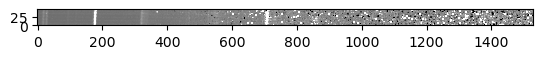

In [42]:
imshow_norm(final_Hg[375:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

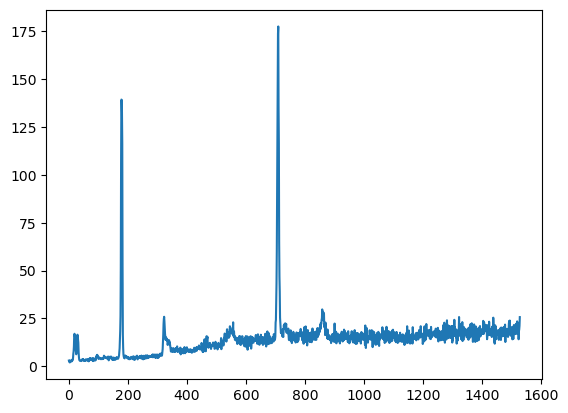

In [43]:
em_Hg = np.nanmedian(final_Hg[375:425,:], axis=0)
px_Hg = np.arange(len(em_Hg))
em_Hg[em_Hg==np.nan] = 0
plt.plot(em_Hg)
# 435.835 nm (blue), 546.074 nm (green)

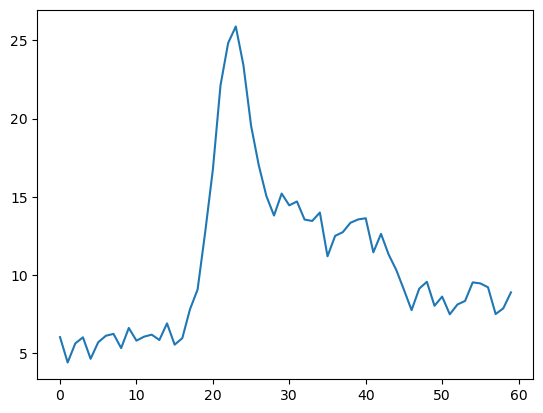

In [44]:
#plt.plot(em_Hg[0:26])
#plt.plot(em_Hg[26:50])
#plt.plot(em_Hg[160:200])
plt.plot(em_Hg[300:360])
#plt.plot(em_Hg[500:600])
#plt.plot(em_Hg[690:730])
#plt.plot(em_Hg[825:900])


In [45]:
cali_Ne = fits.getdata(files_cali[1])

In [46]:
exptime_Ne = fits.getheader(files_cali[1])['EXPTIME']

final_Ne = (cali_Ne - master_bias - (exptime_Ne/exptime_dark_07)*master_dark_07)/(master_norm_flat)

/tmp/ipykernel_5305/1325804219.py:3: RuntimeWarning: divide by zero encountered in true_divide
  final_Ne = (cali_Ne - master_bias - (exptime_Ne/exptime_dark_07)*master_dark_07)/(master_norm_flat)
/tmp/ipykernel_5305/1325804219.py:3: RuntimeWarning: invalid value encountered in true_divide
  final_Ne = (cali_Ne - master_bias - (exptime_Ne/exptime_dark_07)*master_dark_07)/(master_norm_flat)


(<matplotlib.image.AxesImage at 0x7f503de601f0>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f503dea2550>)

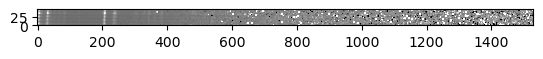

In [47]:
imshow_norm(final_Ne[375:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')


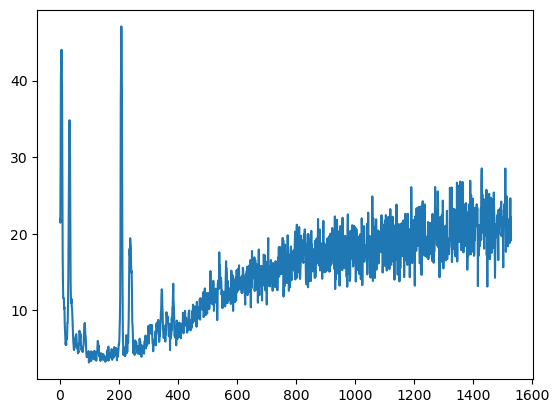

In [48]:
em_Ne = np.nanmedian(final_Ne[375:425,:], axis=0)
plt.plot(em_Ne)

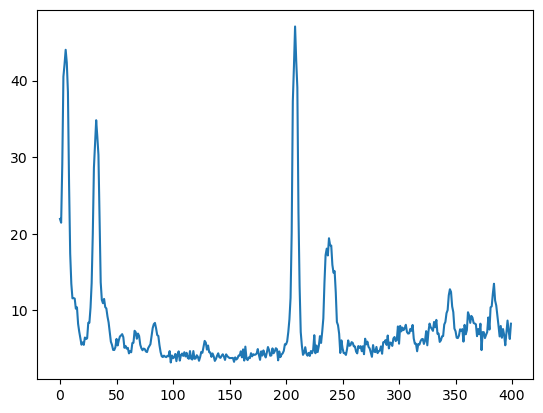

In [49]:
plt.plot(em_Ne[:400])
#plt.plot(em_Ne[0:20])
#plt.plot(em_Ne[20:50])
#plt.plot(em_Ne[190:230])
#plt.plot(em_Ne[230:250])
#plt.plot(em_Ne[330:355])
#plt.plot(em_Ne[355:400])

#### My Group

In [298]:
files_cali2

['/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/mygroup/calibration/Hydrogen_10s.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/mygroup/calibration/Mercury_20s.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/mygroup/calibration/Neon_10s.FIT']

In [299]:
cali2_H  = fits.getdata(files_cali2[0])
cali2_Hg = fits.getdata(files_cali2[1])
cali2_Ne = fits.getdata(files_cali2[2])

In [52]:
exptime2_Hg = fits.getheader(files_cali2[1])['EXPTIME']
final2_Hg = (cali2_Hg - master_bias2 - (exptime2_Hg/exptime_dark2_20)*master_dark2_20)/(master_norm_flat2)

/tmp/ipykernel_5305/786135649.py:2: RuntimeWarning: divide by zero encountered in true_divide
  final2_Hg = (cali2_Hg - master_bias2 - (exptime2_Hg/exptime_dark2_20)*master_dark2_20)/(master_norm_flat2)
/tmp/ipykernel_5305/786135649.py:2: RuntimeWarning: invalid value encountered in true_divide
  final2_Hg = (cali2_Hg - master_bias2 - (exptime2_Hg/exptime_dark2_20)*master_dark2_20)/(master_norm_flat2)


(<matplotlib.image.AxesImage at 0x7f503dd101c0>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f503dd57670>)

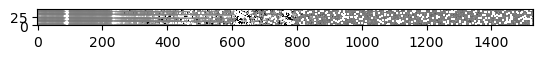

In [53]:
imshow_norm(final2_Hg[375:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

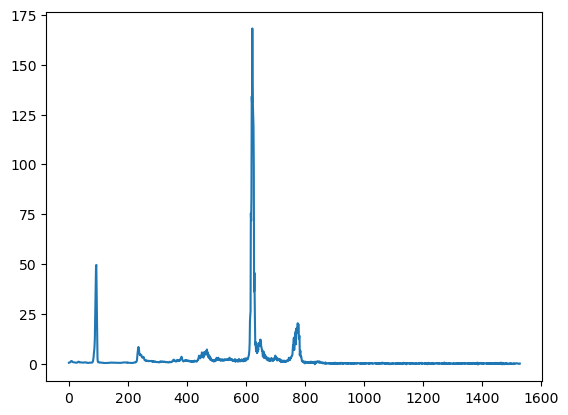

In [300]:
em2_Hg = np.nanmedian(final2_Hg[375:425,:], axis=0)*gain/exptime2_Hg
px2_Hg = np.arange(len(em2_Hg))
plt.plot(em2_Hg)

In [55]:
exptime2_H = fits.getheader(files_cali2[0])['EXPTIME']
final2_H = (cali2_H - master_bias2 - (exptime2_H/exptime_dark2_10)*master_dark2_10)/(master_norm_flat2)

/tmp/ipykernel_5305/2111062723.py:2: RuntimeWarning: divide by zero encountered in true_divide
  final2_H = (cali2_H - master_bias2 - (exptime2_H/exptime_dark2_10)*master_dark2_10)/(master_norm_flat2)
/tmp/ipykernel_5305/2111062723.py:2: RuntimeWarning: invalid value encountered in true_divide
  final2_H = (cali2_H - master_bias2 - (exptime2_H/exptime_dark2_10)*master_dark2_10)/(master_norm_flat2)


(<matplotlib.image.AxesImage at 0x7f503dc50b80>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f503dc98100>)

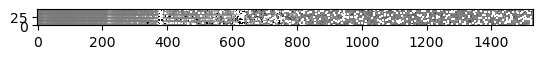

In [56]:
imshow_norm(final2_H[375:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

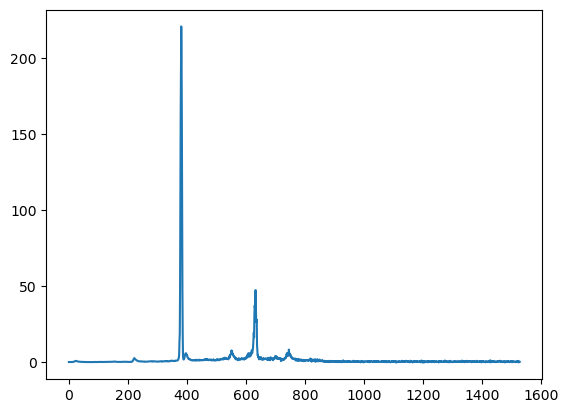

In [301]:
em2_H = np.nanmedian(final2_H[375:425,:], axis=0)*gain/exptime2_H
px2_H = np.arange(len(em2_H))
plt.plot(em2_H)

In [58]:
exptime2_Ne = fits.getheader(files_cali2[1])['EXPTIME']
final2_Ne = (cali2_Ne - master_bias2 - (exptime2_Ne/exptime_dark2_10)*master_dark2_10)/(master_norm_flat2)

/tmp/ipykernel_5305/300449279.py:2: RuntimeWarning: divide by zero encountered in true_divide
  final2_Ne = (cali2_Ne - master_bias2 - (exptime2_Ne/exptime_dark2_10)*master_dark2_10)/(master_norm_flat2)
/tmp/ipykernel_5305/300449279.py:2: RuntimeWarning: invalid value encountered in true_divide
  final2_Ne = (cali2_Ne - master_bias2 - (exptime2_Ne/exptime_dark2_10)*master_dark2_10)/(master_norm_flat2)


(<matplotlib.image.AxesImage at 0x7f503db28580>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f503dbe9100>)

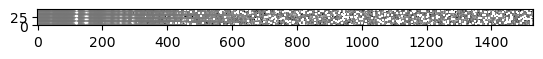

In [59]:
imshow_norm(final2_Ne[375:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

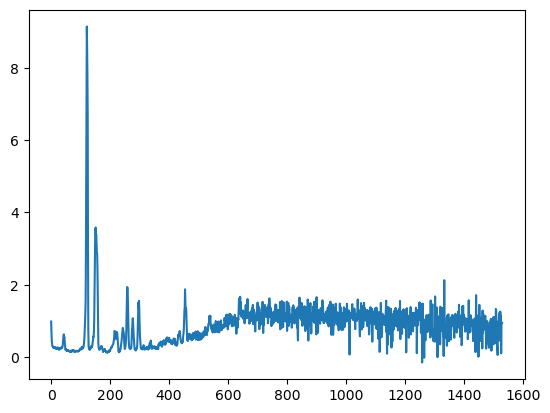

In [302]:
em2_Ne = np.nanmedian(final2_Ne[375:425,:], axis=0)*gain/exptime2_Ne
px2_Ne = np.arange(len(em2_Ne))
plt.plot(em2_Ne)

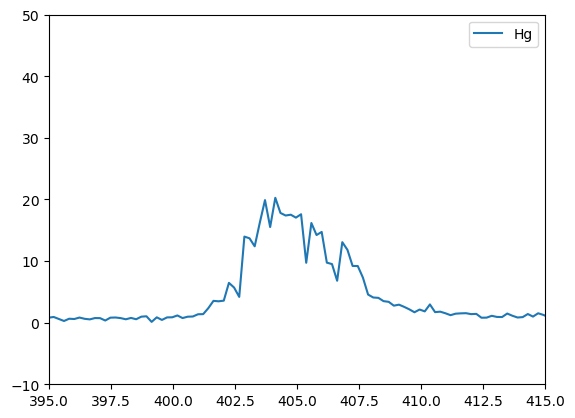

In [304]:
#plt.plot(em2_Hg, label='Hg')
#plt.plot(em2_Ne, label='Ne')
plt.plot(wavelengths, em2_Hg, label='Hg')
#plt.plot(em2_Ne, label='Ne')
#plt.plot(em2_H, label='H')
plt.ylim(top=50, bottom=-10)
plt.xlim(left=395, right=415)
plt.legend()

#There are two other blue lines at 404.656 nm and 407.781 nm and a weak line at 491.604 nm.
# The prominent mercury lines are at 435.835 nm (blue), 546.074 nm (green), and a pair at 576.959 nm and 579.065 nm (yellow-orange).

In [62]:
px_H_633 = 434.047#*u.nm # blue
px_H_382 = 486.133#*u.nm # teal
px_Hg_622 = 435.835#*u.nm # blue
px_Hg_93  = 546.074 #*u.nm # green
px_Ne_121 = 540.05616# *u.nm
px_Ne_151 = 534.10938 #*u.nm

#plt.plot(em2_H[:])
#plt.plot(em2_Hg[:])
#plt.plot(em2_Ne[:])
#plt.ylim(top=200, bottom=-5)

#np.argmax(em2_Ne[140:190])

# The prominent mercury lines are at 435.835 nm (blue), 546.074 nm (green), 
# and a pair at 576.959 nm and 579.065 nm (yellow-orange). There are two other 
# blue lines at 404.656 nm and 407.781 nm and a weak line at 491.604 nm

In [109]:
x = [633, 382, 622, 93, 121, 151]
wave = [px_H_633, px_H_382, px_Hg_622, px_Hg_93, px_Ne_121, px_Ne_151]
fit = curve_fit(lin_fit, x, wave)[0]


In [524]:
print(fit[0], fit[1])

-0.2078095090608855 565.3815295233154


In [518]:
ele = ['Hydrogen', 'Hydrogen', 'Mercury', 'Mercury', 'Neon', 'Neon']
names = ['Pixel', 'Wavelength', 'Element']
tblr_fit = Table([x*u.pixel, wave*u.nm, ele], names=names)
tblr_fit.write('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/table_wavelengthsolu.txt', format='latex', overwrite=True)

In [517]:
pwd

'/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix'

In [110]:
px = np.arange(len(em2_Hg))
wavelengths = lin_fit(px, fit[0], fit[1])

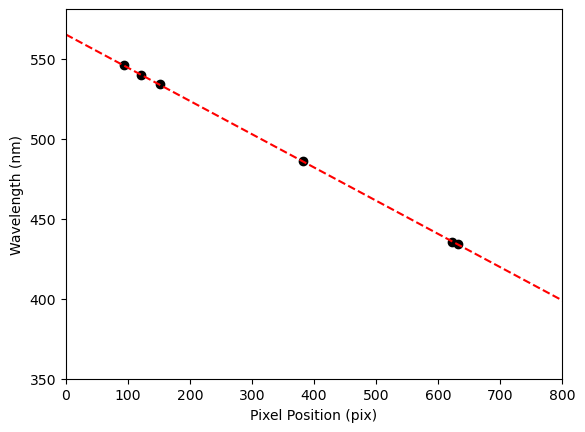

In [550]:
plt.plot(px, wavelengths, '--', color='red')
plt.scatter(x, wave, color='black')
plt.xlim(left=0, right=800)
plt.ylim(bottom=350)
plt.xlabel('Pixel Position (pix)')
plt.ylabel('Wavelength (nm)')
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/plots/wavevpx.pdf', bbox_inches='tight')

In [521]:
fit_c = curve_fit(quad_fit, x, wave)[0]
wavelengths_c = quad_fit(px, fit_c[0], fit_c[1], fit_c[2])

In [523]:
fit_c[0]

-2.2193685731419777e-06

In [519]:
np.max(wavelengths)

565.3815295233154

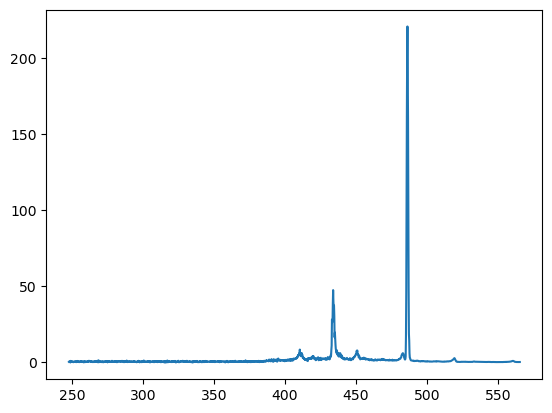

In [305]:
plt.plot(wavelengths, em2_H)

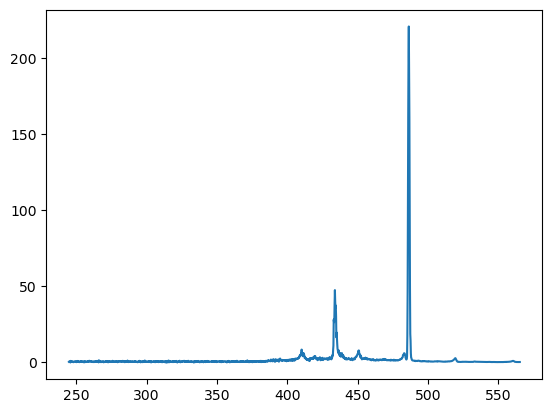

In [522]:
plt.plot(wavelengths_c, em2_H)

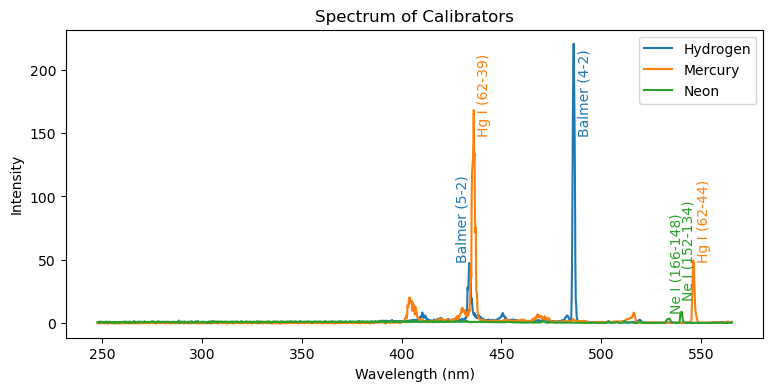

In [392]:
px_H_633 = 434.047#*u.nm # blue
px_H_382 = 486.133#*u.nm # teal
px_Hg_622 = 435.835#*u.nm # blue
px_Hg_93  = 546.074 #*u.nm # green
px_Ne_121 = 540.05616# *u.nm
px_Ne_151 = 534.10938 #*u.nm
H_balmer62 = 410.1734
H_balmer72 = 397.0075
He_line = 537.02992
H_balmer82 = 388.9064

fig = plt.figure(figsize=(9,4))
plt.plot(wavelengths, em2_H, label='Hydrogen', color='tab:blue')
plt.plot(wavelengths, em2_Hg, label='Mercury', color='tab:orange')
plt.plot(wavelengths, em2_Ne, label='Neon', color='tab:green')
plt.title('Spectrum of Calibrators')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.text(px_H_633-7, 50, 'Balmer (5-2)', rotation='vertical', color='tab:blue')
plt.text(px_H_382+2, 150, 'Balmer (4-2)', rotation='vertical', color='tab:blue')
plt.text(px_Hg_622+2, 150, 'Hg I (62-39)', rotation='vertical', color='tab:orange')
plt.text(px_Hg_93+2, 50, 'Hg I (62-44)', rotation='vertical', color='tab:orange')
plt.text(px_Ne_121, 20, 'Ne I (152-134)', rotation='vertical', color='tab:green')
plt.text(px_Ne_151, 10, 'Ne I (166-148)', rotation='vertical', color='tab:green')
plt.legend()
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/plots/calibrators_spectrum.pdf', bbox_inches='tight')

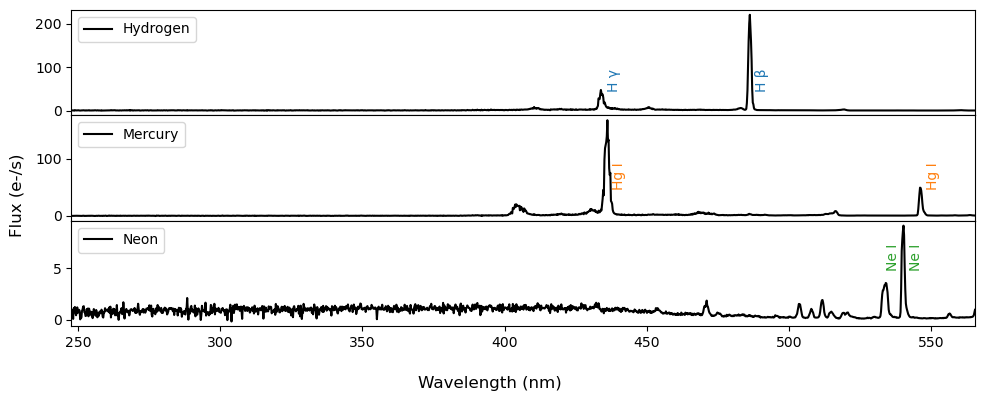

In [486]:
fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.set_figheight(4)
fig.set_figwidth(10)
axs[0].set_xlim(left=np.min(wavelengths), right=np.max(wavelengths))

axs[0].plot(wavelengths, em2_H, label='Hydrogen', color='black')
axs[1].plot(wavelengths, em2_Hg, label='Mercury', color='black')
axs[2].plot(wavelengths, em2_Ne, label='Neon', color='black')

axs[0].text(px_H_633+2,  50, 'H γ', rotation='vertical', color='tab:blue')
axs[0].text(px_H_382+2,  50, 'H β', rotation='vertical', color='tab:blue')
axs[1].text(px_Hg_622+2, 50, 'Hg I', rotation='vertical', color='tab:orange')
axs[1].text(px_Hg_93+2,  50, 'Hg I', rotation='vertical', color='tab:orange')
axs[2].text(px_Ne_121+2, 5, 'Ne I', rotation='vertical', color='tab:green')
axs[2].text(px_Ne_151, 5, 'Ne I', rotation='vertical', color='tab:green')

for ax in fig.get_axes():
    ax.label_outer()
    ax.legend(loc='upper left')
    
fig.supylabel('Flux (e-/s)')
fig.supxlabel('Wavelength (nm)')    

    
fig.tight_layout()
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/plots/calibrators_spectrum.pdf', bbox_inches='tight')

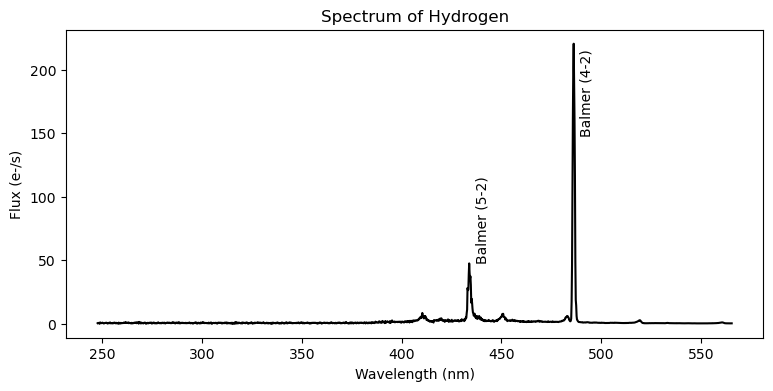

In [391]:
fig = plt.figure(figsize=(9,4))
plt.plot(wavelengths, em2_H, label='Hydrogen', color='black')
plt.text(px_H_633+3, 50, 'Balmer (5-2)', rotation='vertical')
plt.text(px_H_382+3, 150, 'Balmer (4-2)', rotation='vertical')
plt.title('Spectrum of Hydrogen')
plt.ylabel('Flux (e-/s)')
plt.xlabel('Wavelength (nm)')
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/plots/hydrogen_spectrum.pdf', bbox_inches='tight')

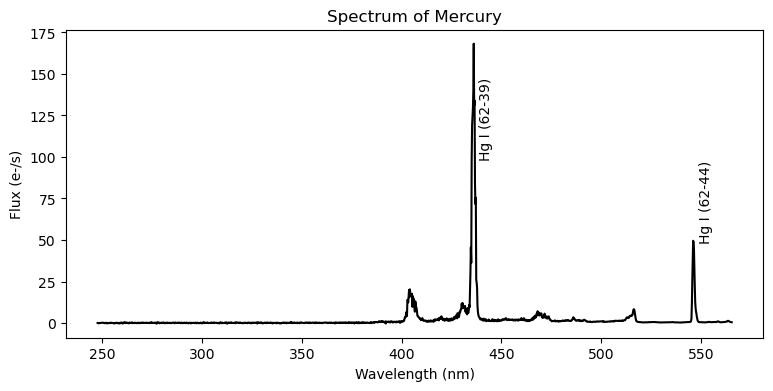

In [390]:
fig = plt.figure(figsize=(9,4))
plt.plot(wavelengths, em2_Hg, label='Mercury', color='black')
plt.text(px_Hg_622+3, 100, 'Hg I (62-39)', rotation='vertical')
plt.text(px_Hg_93+3, 50, 'Hg I (62-44)', rotation='vertical')
plt.title('Spectrum of Mercury')
plt.ylabel('Flux (e-/s)')
plt.xlabel('Wavelength (nm)')
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/plots/mercury_spectrum.pdf', bbox_inches='tight')

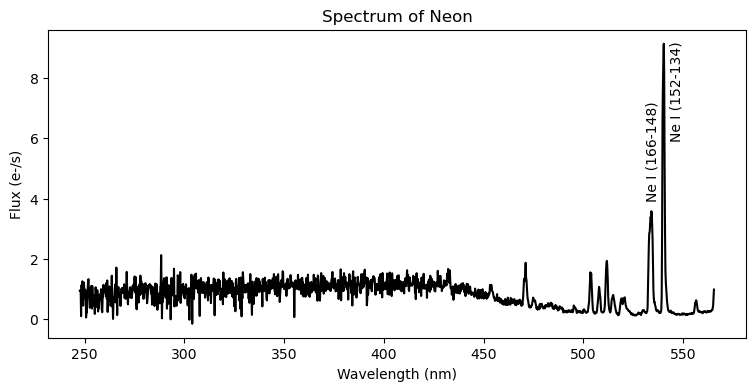

In [389]:
fig = plt.figure(figsize=(9,4))
plt.plot(wavelengths, em2_Ne, label='Neon', color='black')
plt.text(px_Ne_121+3, 6, 'Ne I (152-134)', rotation='vertical')
plt.text(px_Ne_151-3, 4, 'Ne I (166-148)', rotation='vertical')
plt.title('Spectrum of Neon')
plt.ylabel('Flux (e-/s)')
plt.xlabel('Wavelength (nm)')
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/plots/neon_spectrum.pdf', bbox_inches='tight')

### Science

#### Data

In [113]:
exptime_alberio = fits.getheader(files_albr[0])['EXPTIME']
files_albr

['/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/alberio/alberioa_40s_1.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/alberio/alberioa_40s_2.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/alberio/alberioa_40s_3.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/alberio/alberioa_40s_4.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/alberio/alberioa_40s_5.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/alberio/alberiob_40s_1.FIT']

In [123]:
data_alb = np.zeros((len(files_albr), ccd_shape[0], ccd_shape[1]))
for file in range(len(files_albr)):
    alberio = fits.getdata(files_albr[file])
    data_alb[file] = (alberio - master_bias - (exptime_alberio/exptime_dark_40)*master_dark_40)/(master_norm_flat)

/tmp/ipykernel_5305/3063012044.py:4: RuntimeWarning: divide by zero encountered in true_divide
  data_alb[file] = (alberio - master_bias - (exptime_alberio/exptime_dark_40)*master_dark_40)/(master_norm_flat)
/tmp/ipykernel_5305/3063012044.py:4: RuntimeWarning: invalid value encountered in true_divide
  data_alb[file] = (alberio - master_bias - (exptime_alberio/exptime_dark_40)*master_dark_40)/(master_norm_flat)


/home/savannahgramze/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


(<matplotlib.image.AxesImage at 0x7f4fea1d1580>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f4fea254c40>)

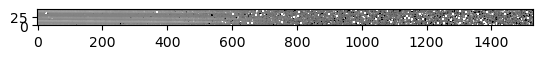

In [234]:
final_alb = np.median(data_alb, axis=0)*gain/exptime_alberio
imshow_norm(final_alb[375:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [128]:
exptime_deneb = fits.getheader(files_denb[0])['EXPTIME']
files_denb

['/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/deneb/deneb_40s_1.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/deneb/deneb_40s_2.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/deneb/deneb_40s_3.FIT']

In [129]:
data_denb = np.zeros((len(files_denb), ccd_shape[0], ccd_shape[1]))
for file in range(len(files_denb)):
    deneb = fits.getdata(files_denb[file])
    data_denb[file] = (deneb - master_bias - (exptime_deneb/exptime_dark_40)*master_dark_40)/(master_norm_flat)

/tmp/ipykernel_5305/631595824.py:4: RuntimeWarning: divide by zero encountered in true_divide
  data_denb[file] = (deneb - master_bias - (exptime_deneb/exptime_dark_40)*master_dark_40)/(master_norm_flat)
/tmp/ipykernel_5305/631595824.py:4: RuntimeWarning: invalid value encountered in true_divide
  data_denb[file] = (deneb - master_bias - (exptime_deneb/exptime_dark_40)*master_dark_40)/(master_norm_flat)


(<matplotlib.image.AxesImage at 0x7f4fea1f5cd0>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f4fea23f8b0>)

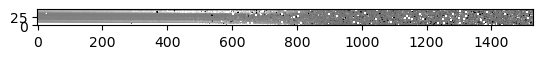

In [233]:
final_denb = np.median(data_denb, axis=0)*gain/exptime_deneb
imshow_norm(final_denb[375:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [135]:
exptime_epsP = fits.getheader(files_epsP[0])['EXPTIME']
files_epsP


['/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/epsPeg/eps_Peg_40s.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/epsPeg/eps_Peg_40s_2.FIT']

In [136]:
data_epsP = np.zeros((len(files_epsP), ccd_shape[0], ccd_shape[1]))
for file in range(len(files_epsP)):
    epsP = fits.getdata(files_epsP[file])
    data_epsP[file] = (epsP - master_bias - (exptime_epsP/exptime_dark_40)*master_dark_40)/(master_norm_flat)

/tmp/ipykernel_5305/814020357.py:4: RuntimeWarning: divide by zero encountered in true_divide
  data_epsP[file] = (epsP - master_bias - (exptime_epsP/exptime_dark_40)*master_dark_40)/(master_norm_flat)
/tmp/ipykernel_5305/814020357.py:4: RuntimeWarning: invalid value encountered in true_divide
  data_epsP[file] = (epsP - master_bias - (exptime_epsP/exptime_dark_40)*master_dark_40)/(master_norm_flat)


(<matplotlib.image.AxesImage at 0x7f4fea2250d0>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f4fea2619a0>)

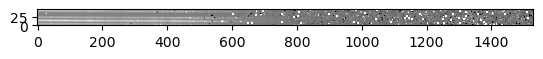

In [231]:
final_epsP = np.median(data_epsP, axis=0)*gain/exptime_epsP
imshow_norm(final_epsP[375:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [139]:
exptime_euro = fits.getheader(files_euro[0])['EXPTIME']
files_euro

['/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/europa/europa_40s_1.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/europa/europa_40s_2.FIT']

In [140]:
data_euro = np.zeros((len(files_euro), ccd_shape[0], ccd_shape[1]))
for file in range(len(files_euro)):
    euro = fits.getdata(files_euro[file])
    data_euro[file] = (euro - master_bias - (exptime_euro/exptime_dark_40)*master_dark_40)/(master_norm_flat)

/tmp/ipykernel_5305/2839034961.py:4: RuntimeWarning: divide by zero encountered in true_divide
  data_euro[file] = (euro - master_bias - (exptime_euro/exptime_dark_40)*master_dark_40)/(master_norm_flat)
/tmp/ipykernel_5305/2839034961.py:4: RuntimeWarning: invalid value encountered in true_divide
  data_euro[file] = (euro - master_bias - (exptime_euro/exptime_dark_40)*master_dark_40)/(master_norm_flat)


(<matplotlib.image.AxesImage at 0x7f4fea2c6520>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f4fea4193a0>)

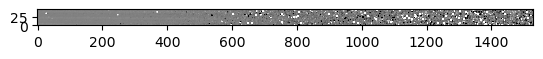

In [230]:
final_euro = np.median(data_euro, axis=0)*gain/exptime_euro
imshow_norm(final_euro[375:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [142]:
exptime_jupi = fits.getheader(files_jupi[0])['EXPTIME']
files_jupi

['/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/jupiter/Jupiter_30s_1.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/jupiter/Jupiter_30s_2.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/jupiter/Jupiter_30s_3.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/jupiter/jupiter_30s_4.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/jupiter/jupiter_30s_5.FIT']

In [143]:
data_jupi = np.zeros((len(files_jupi), ccd_shape[0], ccd_shape[1]))
for file in range(len(files_jupi)):
    jupi = fits.getdata(files_jupi[file])
    data_jupi[file] = (jupi - master_bias - (exptime_jupi/exptime_dark_40)*master_dark_40)/(master_norm_flat)

/tmp/ipykernel_5305/2110104804.py:4: RuntimeWarning: divide by zero encountered in true_divide
  data_jupi[file] = (jupi - master_bias - (exptime_jupi/exptime_dark_40)*master_dark_40)/(master_norm_flat)
/tmp/ipykernel_5305/2110104804.py:4: RuntimeWarning: invalid value encountered in true_divide
  data_jupi[file] = (jupi - master_bias - (exptime_jupi/exptime_dark_40)*master_dark_40)/(master_norm_flat)


(<matplotlib.image.AxesImage at 0x7f4fea3b2cd0>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f4fea470040>)

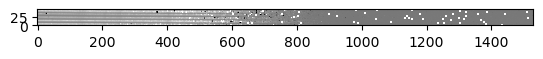

In [229]:
final_jupi = np.median(data_jupi, axis=0)*gain/exptime_jupi
imshow_norm(final_jupi[375:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [145]:
exptime_sunn = fits.getheader(files_sunn[0])['EXPTIME']
files_sunn

['/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/sun/sun_20s001.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/sun/sun_20s002.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/sun/sun_20s003.FIT']

In [146]:
data_sunn = np.zeros((len(files_sunn), ccd_shape[0], ccd_shape[1]))
for file in range(len(files_sunn)):
    sunn = fits.getdata(files_sunn[file])
    data_sunn[file] = (sunn - master_bias - (exptime_sunn/exptime_dark_40)*master_dark_40)/(master_norm_flat)

/tmp/ipykernel_5305/2247231135.py:4: RuntimeWarning: divide by zero encountered in true_divide
  data_sunn[file] = (sunn - master_bias - (exptime_sunn/exptime_dark_40)*master_dark_40)/(master_norm_flat)
/tmp/ipykernel_5305/2247231135.py:4: RuntimeWarning: invalid value encountered in true_divide
  data_sunn[file] = (sunn - master_bias - (exptime_sunn/exptime_dark_40)*master_dark_40)/(master_norm_flat)


(<matplotlib.image.AxesImage at 0x7f4fea39c670>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f4fea4fb2e0>)

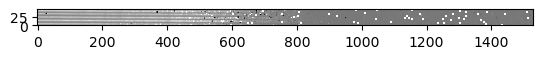

In [228]:
final_sunn = np.median(data_sunn, axis=0)*gain/exptime_sunn
imshow_norm(final_sunn[375:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [149]:
exptime_vega = fits.getheader(files_vega[0])['EXPTIME']
files_vega

['/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/vega/vega_1.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabSixData/othergroup/vega/vega_2.FIT']

In [150]:
data_vega = np.zeros((len(files_vega), ccd_shape[0], ccd_shape[1]))
for file in range(len(files_vega)):
    vega = fits.getdata(files_vega[file])
    data_vega[file] = (vega - master_bias - (exptime_vega/exptime_dark_30)*master_dark_30)/(master_norm_flat)

/tmp/ipykernel_5305/2204874859.py:4: RuntimeWarning: divide by zero encountered in true_divide
  data_vega[file] = (vega - master_bias - (exptime_vega/exptime_dark_30)*master_dark_30)/(master_norm_flat)
/tmp/ipykernel_5305/2204874859.py:4: RuntimeWarning: invalid value encountered in true_divide
  data_vega[file] = (vega - master_bias - (exptime_vega/exptime_dark_30)*master_dark_30)/(master_norm_flat)


/home/savannahgramze/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


(<matplotlib.image.AxesImage at 0x7f4fea408a30>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f4feaaf25e0>)

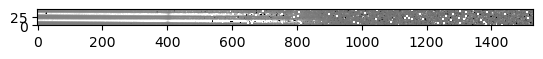

In [227]:
final_vega = np.median(data_vega, axis=0)*gain/exptime_vega
imshow_norm(final_vega[375:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [226]:
gain = fits.getheader(files_vega[0])['EGAIN']

#### Spectra

(<matplotlib.image.AxesImage at 0x7f4fea197e20>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f4fea15ae80>)

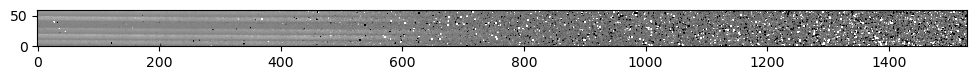

In [235]:
em_alb = np.nanmedian(final_alb[370:425,:], axis=0)
fig = plt.figure(figsize=(12,2))
imshow_norm(final_alb[370:430,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

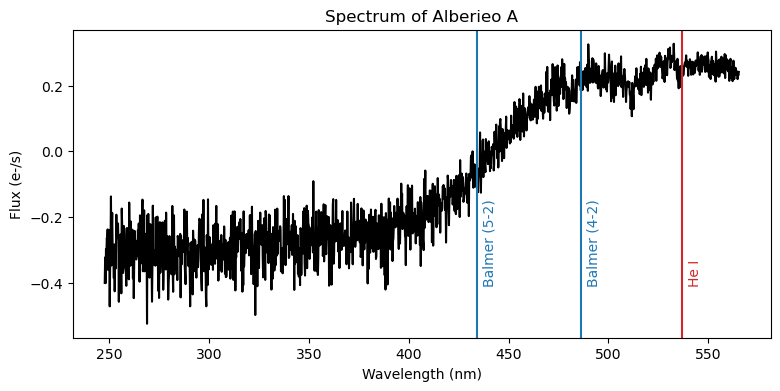

In [388]:
fig = plt.figure(figsize=(9,4))
plt.plot(wavelengths, em_alb, color='black')
plt.axvline(px_H_633, color='tab:blue')
plt.axvline(px_H_382, color='tab:blue')
#plt.axvline(H_balmer62, color='tab:orange')
#plt.axvline(H_balmer72, color='tab:orange')
#plt.axvline(H_balmer82, color='tab:orange')
plt.axvline(He_line, color='tab:red')

plt.title('Spectrum of Alberieo A')
plt.ylabel('Flux (e-/s)')
plt.xlabel('Wavelength (nm)')
plt.text(px_H_633+3, -.4, 'Balmer (5-2)', rotation='vertical', color='tab:blue')
plt.text(px_H_382+3, -.4, 'Balmer (4-2)', rotation='vertical', color='tab:blue')
#plt.text(H_balmer62+3, -2, 'Balmer (6-2)', rotation='vertical', color='tab:orange')
#plt.text(H_balmer72+3, -2, 'Balmer (7-2)', rotation='vertical', color='tab:orange')
#plt.text(H_balmer82-10, -2, 'Balmer (8-2)', rotation='vertical', color='tab:orange')
plt.text(He_line+3, -.4, 'He I', rotation='vertical', color='tab:red')
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/plots/alberioA_spectrum.pdf', bbox_inches='tight')

(<matplotlib.image.AxesImage at 0x7f4fea072c40>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f4fea0c0b80>)

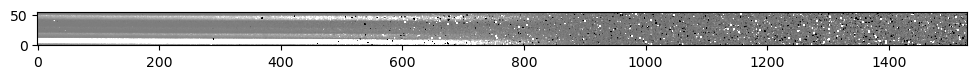

In [237]:
em_denb = np.nanmedian(final_denb[370:425,:], axis=0)
fig = plt.figure(figsize=(12,2))
imshow_norm(final_denb[370:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

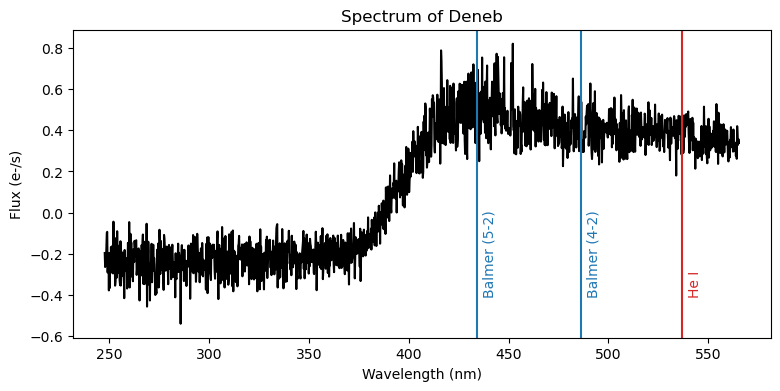

In [387]:
fig = plt.figure(figsize=(9,4))
plt.plot(wavelengths, em_denb, color='black')
plt.axvline(px_H_633, color='tab:blue')
plt.axvline(px_H_382, color='tab:blue')
#plt.axvline(H_balmer62, color='tab:orange')
#plt.axvline(H_balmer72, color='tab:orange')
#plt.axvline(H_balmer82, color='tab:orange')
plt.axvline(He_line, color='tab:red')

plt.title('Spectrum of Deneb')
plt.ylabel('Flux (e-/s)')
plt.xlabel('Wavelength (nm)')
plt.text(px_H_633+3, -.4, 'Balmer (5-2)', rotation='vertical', color='tab:blue')
plt.text(px_H_382+3, -.4, 'Balmer (4-2)', rotation='vertical', color='tab:blue')
#plt.text(H_balmer62+3, -2, 'Balmer (6-2)', rotation='vertical', color='tab:orange')
#plt.text(H_balmer72+3, -2, 'Balmer (7-2)', rotation='vertical', color='tab:orange')
#plt.text(H_balmer82-10, -2, 'Balmer (8-2)', rotation='vertical', color='tab:orange')
plt.text(He_line+3, -.4, 'He I', rotation='vertical', color='tab:red')
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/plots/deneb_spectrum.pdf', bbox_inches='tight')

(<matplotlib.image.AxesImage at 0x7f4fe9fb2d30>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f4fe9ff9730>)

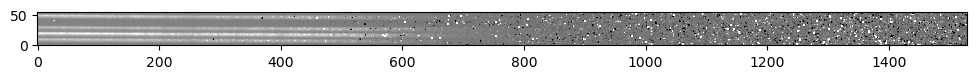

In [239]:
em_epsP = np.nanmedian(final_epsP[370:425,:], axis=0)
fig = plt.figure(figsize=(12,2))
imshow_norm(final_epsP[370:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

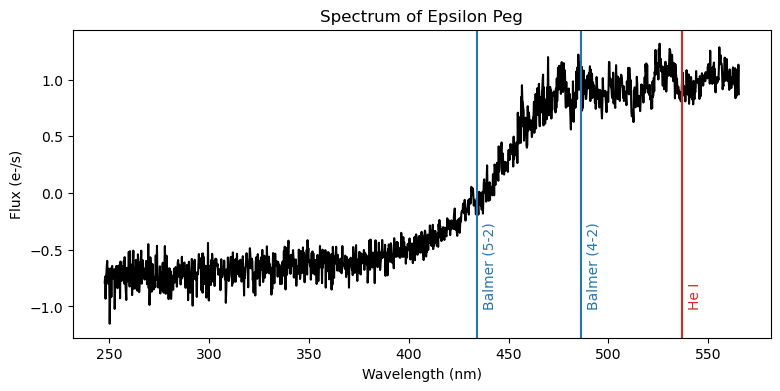

In [386]:
fig = plt.figure(figsize=(9,4))
plt.plot(wavelengths, em_epsP, color='black')
plt.axvline(px_H_633, color='tab:blue')
plt.axvline(px_H_382, color='tab:blue')
#plt.axvline(H_balmer62, color='tab:orange')
#plt.axvline(H_balmer72, color='tab:orange')
#plt.axvline(H_balmer82, color='tab:orange')
plt.axvline(He_line, color='tab:red')

plt.title('Spectrum of Epsilon Peg')
plt.ylabel('Flux (e-/s)')
plt.xlabel('Wavelength (nm)')
plt.text(px_H_633+3, -1, 'Balmer (5-2)', rotation='vertical', color='tab:blue')
plt.text(px_H_382+3, -1, 'Balmer (4-2)', rotation='vertical', color='tab:blue')
#plt.text(H_balmer62+3, -2, 'Balmer (6-2)', rotation='vertical', color='tab:orange')
#plt.text(H_balmer72+3, -2, 'Balmer (7-2)', rotation='vertical', color='tab:orange')
#plt.text(H_balmer82-10, -2, 'Balmer (8-2)', rotation='vertical', color='tab:orange')
plt.text(He_line+3, -1, 'He I', rotation='vertical', color='tab:red')
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/plots/epsPeg_spectrum.pdf', bbox_inches='tight')

(<matplotlib.image.AxesImage at 0x7f4fe9eeed90>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f4fe9f3d0a0>)

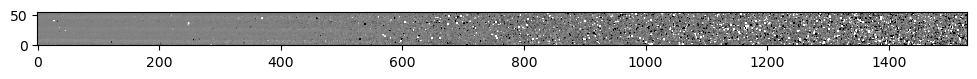

In [241]:
em_euro = np.nanmedian(final_euro[370:425,:], axis=0)
fig = plt.figure(figsize=(12,2))
imshow_norm(final_euro[370:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

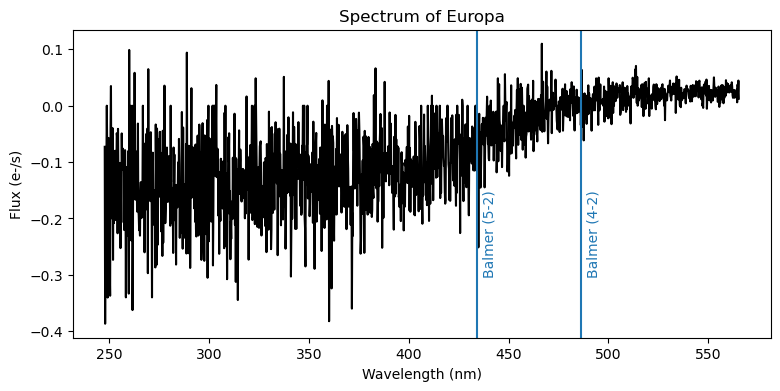

In [385]:
fig = plt.figure(figsize=(9,4))
plt.plot(wavelengths, em_euro, color='black')
plt.axvline(px_H_633, color='tab:blue')
plt.axvline(px_H_382, color='tab:blue')
#plt.axvline(H_balmer62, color='tab:orange')
#plt.axvline(H_balmer72, color='tab:orange')
#plt.axvline(H_balmer82, color='tab:orange')
#plt.axvline(He_line, color='tab:red')

plt.title('Spectrum of Europa')
plt.ylabel('Flux (e-/s)')
plt.xlabel('Wavelength (nm)')
plt.text(px_H_633+3, -.3, 'Balmer (5-2)', rotation='vertical', color='tab:blue')
plt.text(px_H_382+3, -.3, 'Balmer (4-2)', rotation='vertical', color='tab:blue')
#plt.text(H_balmer62+3, -2, 'Balmer (6-2)', rotation='vertical', color='tab:orange')
#plt.text(H_balmer72+3, -2, 'Balmer (7-2)', rotation='vertical', color='tab:orange')
#plt.text(H_balmer82-10, -2, 'Balmer (8-2)', rotation='vertical', color='tab:orange')
#plt.text(He_line+3, -2, 'He I', rotation='vertical', color='tab:red')
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/plots/europa_spectrum.pdf', bbox_inches='tight')

(<matplotlib.image.AxesImage at 0x7f4fe9e33400>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f4fe9e62f70>)

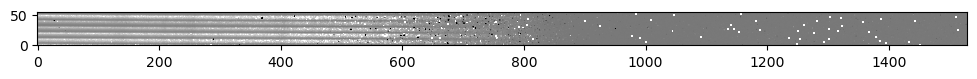

In [243]:
em_jupi = np.nanmedian(final_jupi[370:425,:], axis=0)
fig = plt.figure(figsize=(12,2))
imshow_norm(final_jupi[370:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

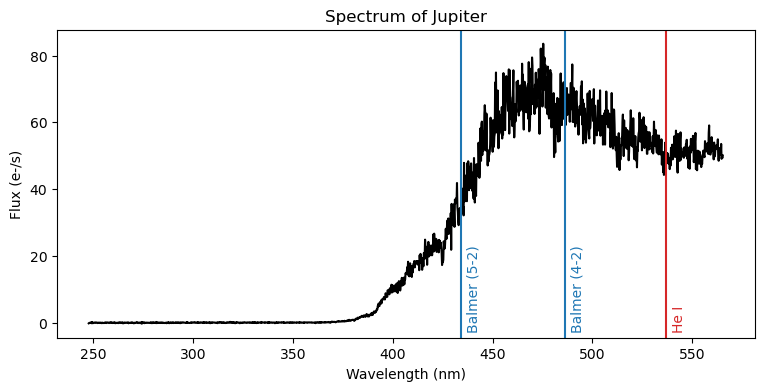

In [384]:
fig = plt.figure(figsize=(9,4))
plt.plot(wavelengths, em_jupi, color='black')
plt.axvline(px_H_633, color='tab:blue')
plt.axvline(px_H_382, color='tab:blue')
#plt.axvline(H_balmer62, color='tab:orange')
#plt.axvline(H_balmer72, color='tab:orange')
#plt.axvline(H_balmer82, color='tab:orange')
plt.axvline(He_line, color='tab:red')

plt.title('Spectrum of Jupiter')
plt.ylabel('Flux (e-/s)')
plt.xlabel('Wavelength (nm)')
plt.text(px_H_633+3, -2, 'Balmer (5-2)', rotation='vertical', color='tab:blue')
plt.text(px_H_382+3, -2, 'Balmer (4-2)', rotation='vertical', color='tab:blue')
#plt.text(H_balmer62+3, -2, 'Balmer (6-2)', rotation='vertical', color='tab:orange')
#plt.text(H_balmer72+3, -2, 'Balmer (7-2)', rotation='vertical', color='tab:orange')
#plt.text(H_balmer82-10, -2, 'Balmer (8-2)', rotation='vertical', color='tab:orange')
plt.text(He_line+3, -2, 'He I', rotation='vertical', color='tab:red')
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/plots/jupiter_spectrum.pdf', bbox_inches='tight')

(<matplotlib.image.AxesImage at 0x7f4fe9d724f0>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f4fe9e01640>)

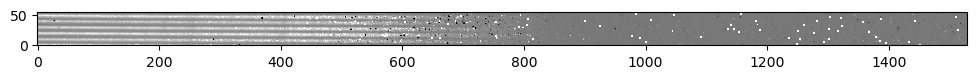

In [245]:
em_sunn = np.nanmedian(final_sunn[370:425,:], axis=0)
fig = plt.figure(figsize=(12,2))
imshow_norm(final_sunn[370:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

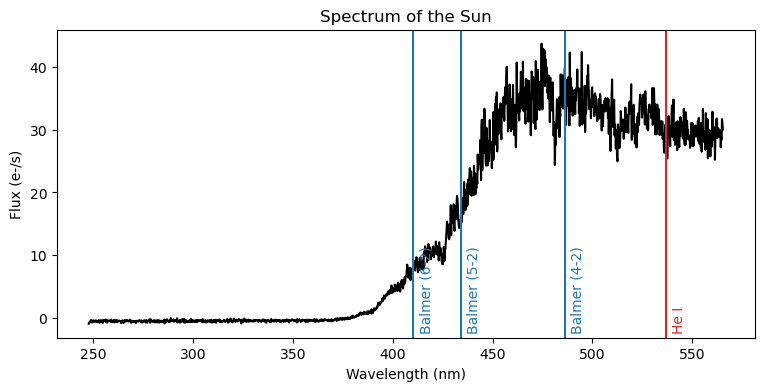

In [383]:
fig = plt.figure(figsize=(9,4))
plt.plot(wavelengths, em_sunn, color='black')
plt.axvline(px_H_633, color='tab:blue')
plt.axvline(px_H_382, color='tab:blue')
plt.axvline(H_balmer62, color='tab:blue')
#plt.axvline(H_balmer72, color='tab:orange')
#plt.axvline(H_balmer82, color='tab:orange')
plt.axvline(He_line, color='tab:red')

plt.title('Spectrum of the Sun')
plt.ylabel('Flux (e-/s)')
plt.xlabel('Wavelength (nm)')
plt.text(px_H_633+3, -2, 'Balmer (5-2)', rotation='vertical', color='tab:blue')
plt.text(px_H_382+3, -2, 'Balmer (4-2)', rotation='vertical', color='tab:blue')
plt.text(H_balmer62+3, -2, 'Balmer (6-2)', rotation='vertical', color='tab:blue')
#plt.text(H_balmer72+3, -2, 'Balmer (7-2)', rotation='vertical', color='tab:orange')
#plt.text(H_balmer82-10, -2, 'Balmer (8-2)', rotation='vertical', color='tab:orange')
plt.text(He_line+3, -2, 'He I', rotation='vertical', color='tab:red')
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/plots/solar_spectrum.pdf', bbox_inches='tight')

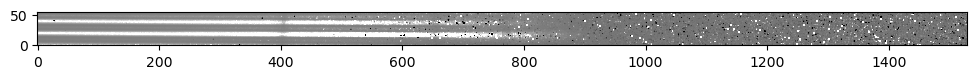

In [525]:
em_vega = np.nanmedian(final_vega[370:425,:], axis=0)
fig = plt.figure(figsize=(12,2))
imshow_norm(final_vega[370:425,:], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/plots/raw_vega_spectrum.pdf', bbox_inches='tight')

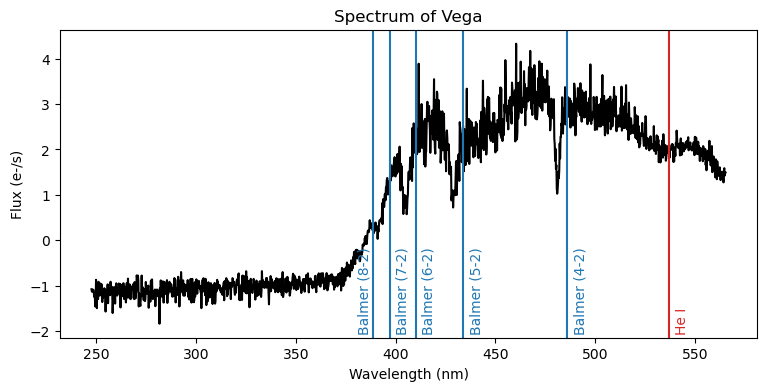

In [382]:
fig = plt.figure(figsize=(9,4))
plt.plot(wavelengths, em_vega, color='black')
plt.axvline(px_H_633, color='tab:blue')
plt.axvline(px_H_382, color='tab:blue')
plt.axvline(H_balmer62, color='tab:blue')
plt.axvline(H_balmer72, color='tab:blue')
plt.axvline(H_balmer82, color='tab:blue')
plt.axvline(He_line, color='tab:red')

plt.title('Spectrum of Vega')
plt.ylabel('Flux (e-/s)')
plt.xlabel('Wavelength (nm)')
plt.text(px_H_633+3, -2, 'Balmer (5-2)', rotation='vertical', color='tab:blue')
plt.text(px_H_382+3, -2, 'Balmer (4-2)', rotation='vertical', color='tab:blue')
plt.text(H_balmer62+3, -2, 'Balmer (6-2)', rotation='vertical', color='tab:blue')
plt.text(H_balmer72+3, -2, 'Balmer (7-2)', rotation='vertical', color='tab:blue')
plt.text(H_balmer82-8, -2, 'Balmer (8-2)', rotation='vertical', color='tab:blue')
plt.text(He_line+3, -2, 'He I', rotation='vertical', color='tab:red')
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/plots/vega_spectrum.pdf', bbox_inches='tight')

In [372]:
pwd

'/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix'

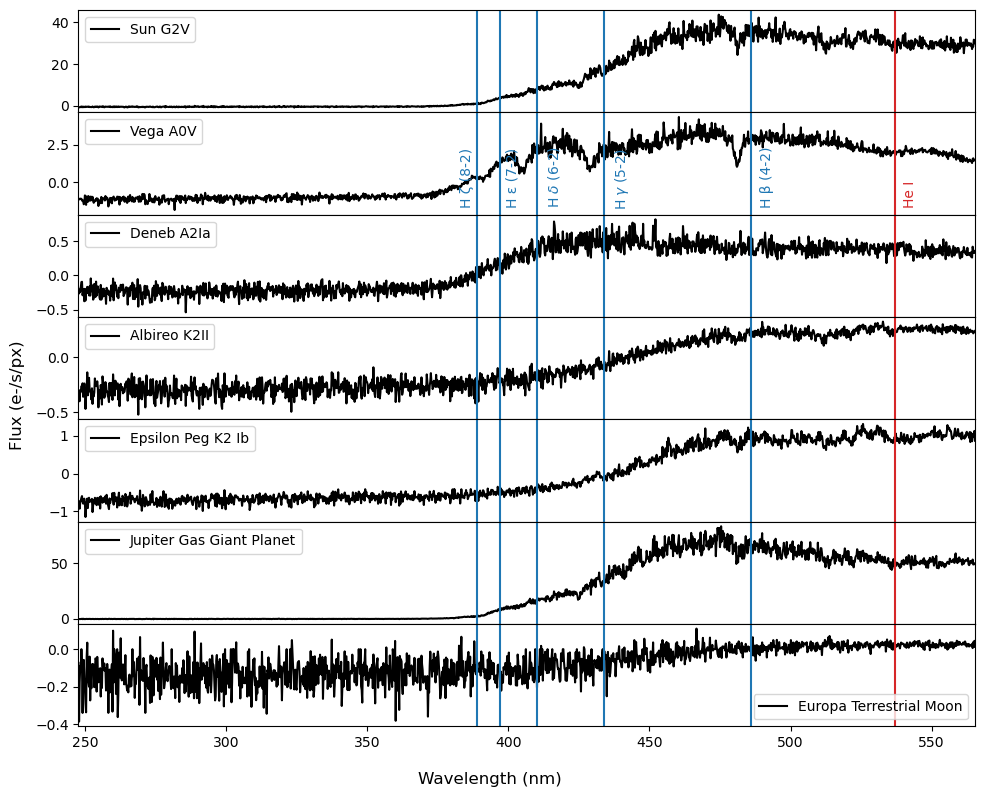

In [541]:
#fig, axs = plt.subplots(7, sharex=True)

fig = plt.figure()
gs = fig.add_gridspec(7, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.set_figheight(8)
fig.set_figwidth(10)
axs[0].set_xlim(left=np.min(wavelengths), right=np.max(wavelengths))

axs[0].plot(wavelengths, em_sunn, color='black', label='Sun G2V')
axs[1].plot(wavelengths, em_vega, color='black', label='Vega A0V')
axs[2].plot(wavelengths, em_denb, color='black', label='Deneb A2Ia')
axs[3].plot(wavelengths, em_alb,  color='black', label='Albireo K2II')
axs[4].plot(wavelengths, em_epsP, color='black', label='Epsilon Peg K2 Ib')
axs[5].plot(wavelengths, em_jupi, color='black', label='Jupiter Gas Giant Planet')
axs[6].plot(wavelengths, em_euro, color='black', label='Europa Terrestrial Moon')

axs[1].text(px_H_633+3,   -1.5, 'H $\gamma$ (5-2)', rotation='vertical', color='tab:blue')
axs[1].text(px_H_382+3,   -1.5, 'H β (4-2)', rotation='vertical', color='tab:blue')
axs[1].text(H_balmer62+3, -1.5, 'H $\delta$ (6-2)', rotation='vertical', color='tab:blue')
axs[1].text(H_balmer72+2, -1.5, 'H ε (7-2)', rotation='vertical', color='tab:blue')
axs[1].text(H_balmer82-6, -1.5, 'H ζ (8-2)', rotation='vertical', color='tab:blue')
axs[1].text(He_line+3,    -1.5, 'He I', rotation='vertical', color='tab:red')

for ax in fig.get_axes():
    ax.label_outer()
    ax.legend()
    ax.axvline(px_H_633, color='tab:blue')
    ax.axvline(px_H_382, color='tab:blue')
    ax.axvline(H_balmer62, color='tab:blue')
    ax.axvline(H_balmer72, color='tab:blue')
    ax.axvline(H_balmer82, color='tab:blue')
    ax.axvline(He_line, color='tab:red')
    
fig.supylabel('Flux (e-/s/px)')
fig.supxlabel('Wavelength (nm)')    
    
    
fig.tight_layout()
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabSix/plots/science_spectrum.pdf', bbox_inches='tight')

In [503]:
#ImageNormalize(final_sunn[370:425,:], interval=ZScaleInterval(), stretch=viz.LinearStretch())

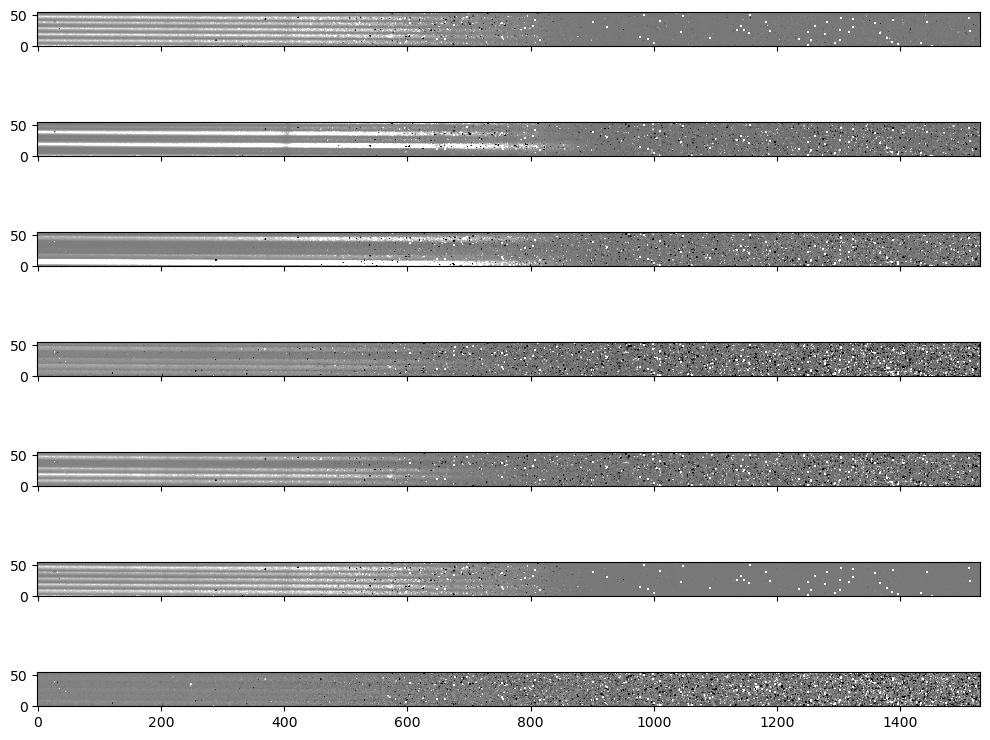

In [511]:
fig = plt.figure()
gs = fig.add_gridspec(7, hspace=0, wspace=0)
axs =gs.subplots(sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(10)
#axs[0].set_xlim(left=np.min(wavelengths), right=np.max(wavelengths))

#axs[0].imshow(final_alb[375:425])
axs[0].imshow(final_sunn[370:425,:], norm=ImageNormalize(final_sunn[370:425,:], interval=ZScaleInterval(), stretch=viz.LinearStretch()), origin='lower', cmap='gray')
axs[1].imshow(final_vega[370:425,:], norm=ImageNormalize(final_vega[370:425,:], interval=ZScaleInterval(), stretch=viz.LinearStretch()), origin='lower', cmap='gray')
axs[2].imshow(final_denb[370:425,:], norm=ImageNormalize(final_denb[370:425,:], interval=ZScaleInterval(), stretch=viz.LinearStretch()), origin='lower', cmap='gray')
axs[3].imshow(final_alb[370:425,:] , norm=ImageNormalize(final_alb[370:425,:] , interval=ZScaleInterval(), stretch=viz.LinearStretch()), origin='lower', cmap='gray')
axs[4].imshow(final_epsP[370:425,:], norm=ImageNormalize(final_epsP[370:425,:], interval=ZScaleInterval(), stretch=viz.LinearStretch()), origin='lower', cmap='gray')
axs[5].imshow(final_jupi[370:425,:], norm=ImageNormalize(final_jupi[370:425,:], interval=ZScaleInterval(), stretch=viz.LinearStretch()), origin='lower', cmap='gray')
axs[6].imshow(final_euro[370:425,:], norm=ImageNormalize(final_euro[370:425,:], interval=ZScaleInterval(), stretch=viz.LinearStretch()), origin='lower', cmap='gray')

for ax in fig.get_axes():
    ax.label_outer()
fig.tight_layout()

In [527]:
temp_sunn = 5772*u.K
temp_vega = 9602*u.K
temp_denb = 8525*u.K
temp_alb  = 4383*u.K
temp_epsP = 3963*u.K
temp_jupi = 165*u.K
temp_euro = 110*u.K

In [530]:
wein = (2.898*10**(-3)*u.m*u.K).to(u.nm*u.K)

In [533]:
peak_sunn = wein/temp_sunn
peak_vega = wein/temp_vega
peak_denb = wein/temp_denb
peak_alb  = wein/temp_alb 
peak_epsP = wein/temp_epsP
peak_jupi = wein/temp_jupi
peak_euro = wein/temp_euro

In [534]:
peak_sunn

<Quantity 502.07900208 nm>

In [535]:
peak_vega

<Quantity 301.81212247 nm>

In [536]:
peak_denb

<Quantity 339.94134897 nm>

In [537]:
peak_alb

<Quantity 661.19096509 nm>

In [538]:
peak_epsP

<Quantity 731.26419379 nm>

In [539]:
peak_jupi

<Quantity 17563.63636364 nm>

In [540]:
peak_euro

<Quantity 26345.45454545 nm>